# LDA model 2
- filter out least and most common hcpcs_codes (compared to model 1, which does no filtering)
- still only consider out-of-facility claims
- reduce number of topics to 8

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi, place_of_service, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments WHERE provider_type = 'Internal Medicine' and place_of_service='O'"""
payments = pd.read_sql_query(q, con=con)

## construct raw dataframe

In [4]:
## out of facility claims
by_npi = (payments.query('place_of_service == "O"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

In [5]:
by_npi.shape

(57331, 1877)

In [5]:
## in facility claims
#by_npi_F = (payments.query('place_of_service == "F"')[['npi','hcpcs_code','bene_day_srvc_cnt']].
#                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
#                fillna(value=0))

In [9]:
#by_npi = pd.merge(by_npi_O, by_npi_F, suffixes=['_O', '_F'])

## preprocess dataframe

### filter out extreme hcpcs_code columns (top 15 claimed codes, codes with fewer than 5 claims)

In [6]:
## What are the counts for the top claimed codes?
counts_per_code = (payments.loc[payments.place_of_service == "O", 'hcpcs_code'].
                   value_counts().
                   reset_index(name='count').
                   rename(columns={'index': 'hcpcs_code'}))

pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(payments[['hcpcs_code', 'hcpcs_description']],
                                         on='hcpcs_code', sort=False)
                   .drop_duplicates())

top_codes_to_drop = counts_per_code['hcpcs_code'][:15]
counts_per_code.head(15)

,hcpcs_code,count,hcpcs_description
0,99214,48243,"Established patient office or other outpatient, visit typically 25 minutes"
48243,99213,47883,"Established patient office or other outpatient visit, typically 15 minutes"
96126,G0008,35191,Administration of influenza virus vaccine
131317,93000,29256,Routine EKG using at least 12 leads including interpretation and report
160573,36415,23296,Insertion of needle into vein for collection of blood sample
183869,G0439,18769,"Annual wellness visit, includes a personalized prevention plan of service (p..."
202638,99215,18275,"Established patient office or other outpatient, visit typically 40 minutes"
220913,G0009,17884,Administration of pneumococcal vaccine
238797,99204,16355,"New patient office or other outpatient visit, typically 45 minutes"
255152,90732,15427,Vaccine for pneumococcal polysaccharide for injection beneath the skin or in...


In [7]:
## How many codes have been claimed less than 5 times?
bottom_codes_to_drop = counts_per_code.query('count < 5')['hcpcs_code']

In [8]:
## so total columns dropped is:
print('number of cols to drop: {0}'.format(len(bottom_codes_to_drop) + len(top_codes_to_drop)))

number of cols to drop: 787


In [9]:
by_npi.drop(labels=(list(top_codes_to_drop) + list(bottom_codes_to_drop)), axis=1, inplace=True)
by_npi.shape

(57331, 1090)

###  drop doctors who have claimed fewer than 5 codes

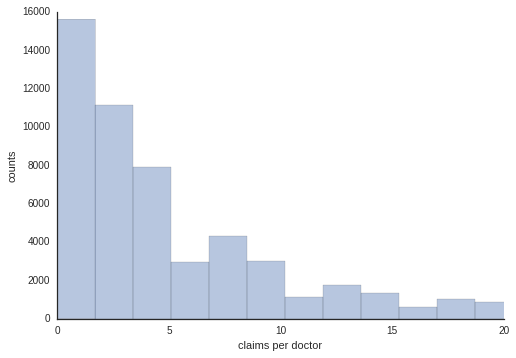

In [12]:
## How many different drug codes have been claimed per doctor?  Plot distribution

#number_of_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot((by_npi > 0.0).sum(axis = 1), kde=False, bins=80)
g.set(xlim=(0,20), xlabel='claims per doctor', ylabel='counts')
sns.despine()

In [11]:
# number of docs to drop (docs who have < 5 claims, based on the already column-filtered dataframe)
sum((by_npi > 0.0).sum(axis = 1) < 5)

31074

In [16]:
by_npi = by_npi[(by_npi > 0.0).sum(axis = 1) >= 5]

In [23]:
by_npi.shape

(26257, 1090)

In [24]:
by_npi.to_csv("11c_by_npi_reduced_dataframe.csv")

### How many fraud doctors are in this reduced data frame?

In [43]:
fraud_npi = pd.read_csv("13_count_out_of_facility_claims_fraud_drs.csv", dtype={'npi':str})

In [44]:
sum(by_npi.index.isin(list(fraud_npi['npi'])))

20

## LDA on filtered data frame using 8 topics

In [27]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [28]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [85]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=5, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 330.0618886947632s


In [109]:
## Save model
ldamodel.save("11c_lda_5topics_colsDropped_docsDropped.model", pickle_protocol=3)

## Interpret the 10 topics in the model

In [86]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15)

In [87]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [88]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [89]:
## Topic 0
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,99203,"New patient office or other outpatient visit, typically 30 minutes"
25,20610,Aspiration and/or injection of large joint or joint capsule
52,71020,"X-ray of chest, 2 views, front and side"
162,94060,"Measurement and graphic recording of the amount and speed of breathed air, b..."
166,94729,Measurement of lung diffusing capacity
173,G0434,"Drug screen, other than chromatographic; any number of drug classes, by clia..."
184,81002,"Urinalysis, manual test"
317,J0696,"Injection, ceftriaxone sodium, per 250 mg"
318,J1030,"Injection, methylprednisolone acetate, 40 mg"
392,J3301,"Injection, triamcinolone acetonide, not otherwise specified, 10 mg"


In [90]:
## Topic 1
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
16,93306,"Ultrasound examination of heart including color-depicted blood flow rate, di..."
17,93880,Ultrasound scanning of blood flow (outside the brain) on both sides of head ...
27,96365,"Infusion into a vein for therapy, prevention, or diagnosis up to 1 hour"
30,96413,Infusion of chemotherapy into a vein up to 1 hour
184,81002,"Urinalysis, manual test"
185,82962,Blood glucose (sugar) test performed by hand-held instrument
482,93015,Exercise or drug-induced heart and blood vessel stress test with EKG monitor...
504,G0447,"Face-to-face behavioral counseling for obesity, 15 minutes"
636,G0444,"Annual depression screening, 15 minutes"
664,83037,Hemoglobin A1C level


In [91]:
## Topic 2
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
153,99334,"Established patient assisted living visit, typically 15 minutes"
154,99335,"Established patient assisted living visit, typically 25 minutes"
155,99336,"Established patient assisted living visit, typically 40 minutes"
181,G0179,Physician re-certification for medicare-covered home health services under ...
284,99349,"Established patient home visit, typically 40 minutes"
320,99306,"Initial nursing facility visit, typically 45 minutes per day"
321,99308,"Subsequent nursing facility visit, typically 15 minutes per day"
322,99309,"Subsequent nursing facility visit, typically 25 minutes per day"
323,99310,"Subsequent nursing facility visit, typically 35 minutes per day"
325,99337,"Established patient assisted living visit, typically 60 minutes"


In [92]:
## Topic 3
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
0,90662,Vaccine for influenza for injection into muscle
2,99203,"New patient office or other outpatient visit, typically 30 minutes"
8,Q2038,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
45,90686,Vaccine for influenza administered into muscle to individuals 3 years of age...
57,81003,Automated urinalysis test
59,83036,Hemoglobin A1C level
90,90670,Pneumococcal vaccine for injection into muscle
139,G0438,Annual wellness visit; includes a personalized prevention plan of service (p...
181,G0179,Physician re-certification for medicare-covered home health services under ...
184,81002,"Urinalysis, manual test"


In [93]:
## Topic 4
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
54,80048,"Blood test, basic group of blood chemicals"
55,80053,"Blood test, comprehensive group of blood chemicals"
56,80061,"Blood test, lipids (cholesterol and triglycerides)"
57,81003,Automated urinalysis test
58,82043,Urine microalbumin (protein) level
59,83036,Hemoglobin A1C level
60,84439,Thyroxine (thyroid chemical) measurement
61,84443,"Blood test, thyroid stimulating hormone (TSH)"
62,85025,"Complete blood cell count (red cells, white blood cell, platelets), automate..."
80,81001,Manual urinalysis test with examination using microscope


## Plot distribution of providers per topic

In [95]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

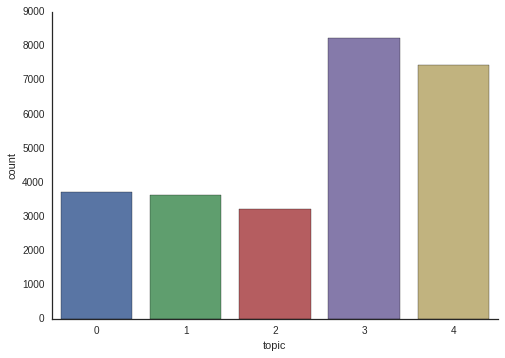

In [96]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

## fraudulent providers

In [45]:
## color code for plotting
fraud_idx = by_npi.index.isin(list(fraud_npi['npi']))
len(fraud_idx)

26257

In [46]:
fraud_label = pd.DataFrame(fraud_idx, columns=['fraud'])
fraud_label.loc[fraud_idx, 'fraud'] = '1'   # 1 for fraud
fraud_label.loc[~fraud_idx, 'fraud'] = '0'

In [97]:
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
                        rename(columns={0:'topic',1:'fraud'}))

In [98]:
mydf = (topic_per_doc_df.reset_index().
        groupby(['topic','fraud']).
        count().
        rename(columns={'index':'counts'}).
        reset_index())

In [99]:
## rescale each of the counts by overall total per fraud group
mydf.loc[mydf.fraud == '0', 'counts']  = (mydf.loc[mydf.fraud == '0', 'counts'] / 
                                          float(sum(mydf.loc[mydf.fraud == '0', 'counts'])))
mydf.loc[mydf.fraud == '1', 'counts']  = (mydf.loc[mydf.fraud == '1', 'counts'] / 
                                          float(sum(mydf.loc[mydf.fraud == '1', 'counts'])))

In [100]:
mydf

,topic,fraud,counts
0,0,0,0.141518
1,0,1,0.350000
2,1,0,0.138240
3,1,1,0.150000
4,2,0,0.122575
5,2,1,0.300000
6,3,0,0.313679
7,3,1,0.150000
8,4,0,0.283988
9,4,1,0.050000


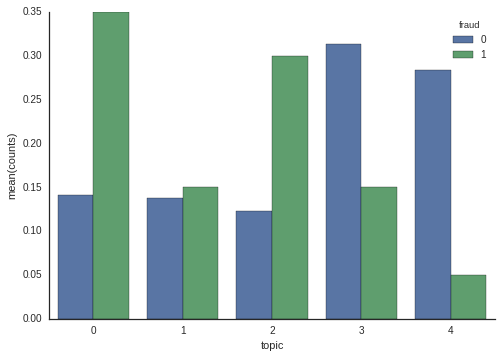

In [101]:
ax = sns.barplot(x='topic', y='counts', hue='fraud', data=mydf)
sns.despine()

## Plot doctors in topic space

In [102]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(26257, 5)

In [81]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

In [103]:
X_centered = preprocessing.scale(by_npi_topics.as_matrix(), with_mean=True, with_std=False)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.45091323,  0.25232198,  0.15089339])

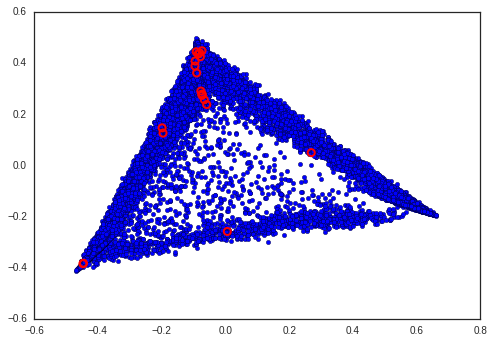

In [104]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,1], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

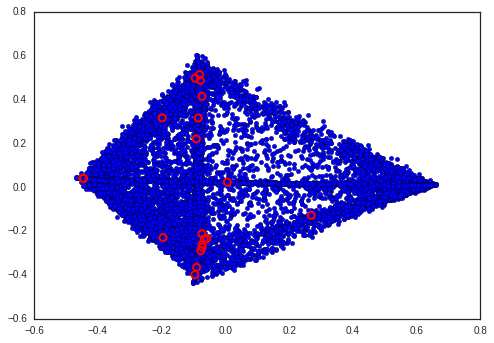

In [105]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,0], X_reduced[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

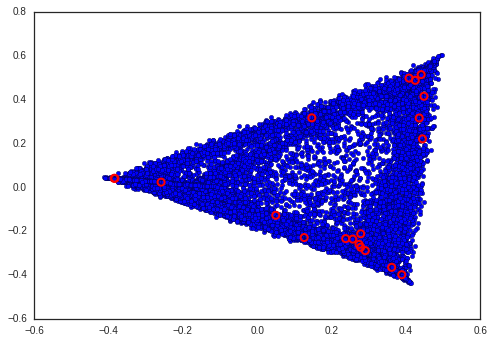

In [106]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])
plt.scatter(X_reduced[fraud_idx,1], X_reduced[fraud_idx,2], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')

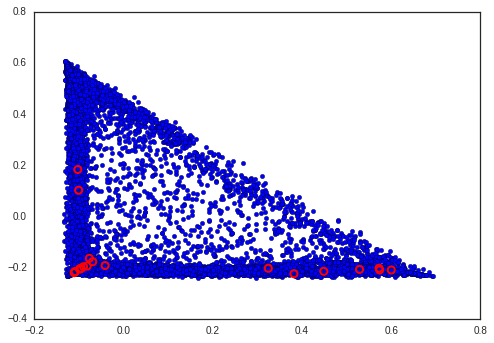

In [108]:
# in original space (topics 0 and 4)
plt.scatter(X_centered[:,0], X_centered[:,4])
plt.scatter(X_centered[fraud_idx, 0], X_centered[fraud_idx, 4], 
                    facecolor='none', s=50, linewidths=2, edgecolors='r')